In [ ]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
import os
load_dotenv()
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_astradb import AstraDBVectorStore
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate

from langchain_openai import ChatOpenAI

In [9]:
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")

In [10]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    max_tokens=1000,
    streaming=True,
    api_key=os.getenv("OPENAI_API_KEY")
)

embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en")


In [ ]:
loader = TextLoader(r'')
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=50)
chunks= text_splitter.split_documents(docs)


In [30]:
vector_store = AstraDBVectorStore(
    collection_name="testt",
    embedding=embeddings,
    api_endpoint=ASTRA_DB_API_ENDPOINT,
    token=ASTRA_DB_APPLICATION_TOKEN,
    namespace="default_keyspace",
    setup_mode="AUTO_DETECT"
    
)


In [31]:
vector_store.add_documents(chunks)

['d43ae9eee3744a46bd739bded04e67f4',
 'b64316bd753c4aff87d10051b4686820',
 '9bbbe55f4c8d4164ac0b703d23908529',
 'eaa9df66b03549678d2e24d1fc76b45d',
 'e7857d41306b475886fe70b894d6bde3',
 'ffd0a162a3b7416895e41ba72866cd0b',
 'fb835eb1cbec44a2a499f6289d0c65b1',
 '0577dc42cda84f548a48aaea1e6a6ccd',
 '1e257a6d7af549909ee5a9847eacaa30',
 '7631cab949fb45829571dead4a39555e',
 '3f62a0ea94a347bca8550935d09b8714',
 'cd875c6822464635a5f273c917c5eed0',
 '51ae07204e68421e9ee35481289bea78',
 '7f093347b73b43e2813c7d1bd628a146',
 'ec11d02594164cb394736e8cc7d1ec55',
 '69582e4904654358a3c3d514de8a8318',
 '88a35cb4cc8d4e25aa53bfb6ecf192a1',
 'bed46017cf164796ae73b9616f449d24',
 '0585bb851b7047ad9b96c8aafa7b884e',
 '178b9cb64ba94c23b29023f82acb2743',
 'f060cfbb6e5e4600a926806792938090',
 '617aa2a6be1e49f1b16e9d487b36772a',
 '8764ef3e238a4e5a9c895b6acf8f94b9',
 '82706d5cb5db401b8ccca56592ed50c6',
 '7c0d39a2cb0443508e9857e2f223ef80',
 '8b46f30f451f4bafa229e9cee1298c24',
 '3500f547a20c4ce8bccac8425569b62b',
 

In [ ]:
retriever = vector_store.as_retriever(search_type="mmr", search_kwargs={"k": 5})
retriever.invoke("what happen in 9/11")

In [34]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [35]:
from langchain.output_parsers import PydanticOutputParser
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")



parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}}, "required": ["Topic"]}
```


In [ ]:
def supervisor_node(state: AgentState):

    query = state["messages"][-1]       
    prompt = '''You are a decision-making AI assistant that selects the appropriate processing module for a user's question.

Here are the available modules:

1. "LLM" — Use for general-purpose generation, creative writing, or general conversational queries not related to 9/11 or requiring up-to-date information.

2. "RAG" — Use ONLY if the question is specifically about the September 11, 2001 (9/11) attacks, including events, people, aftermath, or historical impact, as covered in internal documents.

3. "Web Crawler" — Use if the question requires current events, recent news, live data, or anything not covered in internal documents.

Respond ONLY with one of: LLM, RAG, or Web Crawler

User Query: {user_input}
{format_instructions}
'''



    template = ChatPromptTemplate.from_template(template=prompt, input_variable = ["user_input"],partial_variables = {"format_instructions": parser.get_format_instructions()})

    chain = template|llm|parser
    response = chain.invoke({"user_input": query})
    print(f"supervisor decides topic: {response.Topic}")
    return {"messages":[response.Topic]}

In [38]:
def router(state: AgentState):
    Topic = state["messages"][-1]  # ✅ get actual message string
    # print(f"router state: {state}")
    
    topic_lower = Topic.lower().strip()  # ✅ normalize

    if topic_lower == "rag":
        return "RAG CALL"
    elif topic_lower == "llm":
        return "LLM CALL"
    else:
        return "Web Crawler CALL"


In [18]:
def llm_node(state: AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    print("Question:", question)

    print(f"state ata llm node :{state}")
    template = ChatPromptTemplate.from_template('''you are an ai assitant give answer based on the user query.
    User Query: {question}
    ''')

    llmNodeChain = template | llm 
    response = llmNodeChain.invoke({"question":question})
    return {"messages": [response.content]}

In [ ]:
def rag_node(state: AgentState):
    print("-> RAG Call ->")
    question = state["messages"][0]
    print("Question:", question)
    print(f"state at rag node :{state}")
    
    prompt = ChatPromptTemplate.from_template(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.\nQuestion: {question} \nContext: {context} \nAnswer:""",
    )
    
    rag_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
    )
    
    result = rag_chain.invoke(question)
    return {"messages": [result.content]}

In [25]:
from langchain_community.utilities import SerpAPIWrapper
def webcrawler_node(state: AgentState):
    print("-> Web Crawler Call ->")
    question = state["messages"][0]
    print("Question:", question)
    print(f"state at webcrawler_node :{state}")
    
    search = SerpAPIWrapper(serpapi_api_key=os.getenv('serpapi_api_key'))
    response = search.run(question)

    
    return {"messages": [response]}

In [ ]:

class Validator(BaseModel):
    validation: str = Field(description="validate and respond wiith 'Correct' or 'Not correct'")

validator_parser = PydanticOutputParser(pydantic_object=Validator)

def validator(state: AgentState):
    print("-> VALIDATOR ->")
    print(f"validaotro agentstate {state}")

    
    question =  state["messages"][0]
    response =  state["messages"][-1]
    
    # Build the prompt
    template = ChatPromptTemplate.from_template("""
You are a validator AI. Your task is to evaluate if the provided answer correctly answers the given question.

Question: {question}
Answer: {response}
{format_instructions}

Is the answer correct? Respond with Correct or Not correct and a short explanation.
""", partial_variables={"format_instructions": validator_parser.get_format_instructions()})
    
    # Simple output parser
    validator_chain = template | llm | validator_parser
    
    result = validator_chain.invoke({"question": question, "response": response})
    
    print("Validation response:", result.validation)
    return {"messages": [result.validation]}          


In [21]:
def validator_router(state: AgentState):
    print("-> VALIDATOR ROUTER ->")
    print(f"state at validator_router: {state}")
    validation_result = state["messages"][-1]
    print("Validation result:", validation_result)
    return validation_result
    

In [58]:
def end_node(state: AgentState):
    final_output = state["messages"][-2]
    print("-> END NODE ->")
    # print(f"Final state: {state}")
    print(f"final output--->: {final_output}") # print(final_output)


In [59]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node('supervisor', supervisor_node)
workflow.add_node('RAG', rag_node)
workflow.add_node('LLM', llm_node)
workflow.add_node('Web Crawler', webcrawler_node)
workflow.add_node('validator', validator)
workflow.add_node('end_node', end_node)


workflow.add_edge('LLM', 'validator')
workflow.add_edge('RAG', 'validator')
workflow.add_edge('Web Crawler', 'validator')



workflow.add_conditional_edges("supervisor", router, {
                    # ✅ matches router output
    "RAG CALL": "RAG",
    "LLM CALL": "LLM",
    "Web Crawler CALL": "Web Crawler"
})


workflow.add_conditional_edges(
    "validator", 
    validator_router, 
    {
        "Correct": 'end_node',
        "Not correct": "supervisor"
    }
) 
workflow.set_entry_point('supervisor')

# workflow.add_edge('validator', 'end_node')
workflow.add_edge('end_node', END)


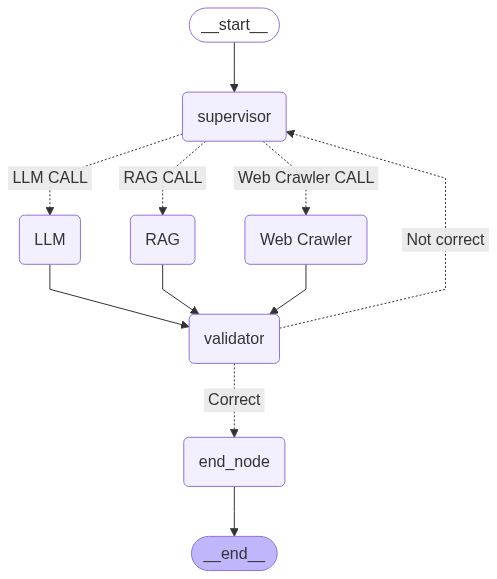

In [60]:
app=workflow.compile()
app

In [61]:
app.invoke({"messages": ["What happen in 9/11?"]})


response.Topic: RAG
-> RAG Call ->
Question: What happen in 9/11?
state ata rag node :{'messages': ['What happen in 9/11?', 'RAG']}
-> VALIDATOR ->
validaotro agentstate {'messages': ['What happen in 9/11?', 'RAG', 'On September 11, 2001, a coordinated attack occurred in which four commercial airplanes were seized mid-flight shortly after takeoff. This event irrevocably changed the world and had significant implications for global politics and economics, leading to shocks in financial markets and declines in industries such as tourism and airlines, while boosting sectors like defense and cybersecurity.']}
Validation result: <class '__main__.Validator'> validation='Correct'
Validation response: Correct
-> VALIDATOR ROUTER ->
state at validator_router: {'messages': ['What happen in 9/11?', 'RAG', 'On September 11, 2001, a coordinated attack occurred in which four commercial airplanes were seized mid-flight shortly after takeoff. This event irrevocably changed the world and had significan

{'messages': ['What happen in 9/11?',
  'RAG',
  'On September 11, 2001, a coordinated attack occurred in which four commercial airplanes were seized mid-flight shortly after takeoff. This event irrevocably changed the world and had significant implications for global politics and economics, leading to shocks in financial markets and declines in industries such as tourism and airlines, while boosting sectors like defense and cybersecurity.',
  'Correct']}

In [62]:
app.invoke({"messages": ["what is capital of india?"]})

response.Topic: LLM
-> LLM Call ->
Question: what is capital of india?
state ata llm node :{'messages': ['what is capital of india?', 'LLM']}
-> VALIDATOR ->
validaotro agentstate {'messages': ['what is capital of india?', 'LLM', 'The capital of India is New Delhi.']}
Validation result: <class '__main__.Validator'> validation='Correct'
Validation response: Correct
-> VALIDATOR ROUTER ->
state at validator_router: {'messages': ['what is capital of india?', 'LLM', 'The capital of India is New Delhi.', 'Correct']}
Validation result: Correct
-> END NODE ->
final output--->: The capital of India is New Delhi.


{'messages': ['what is capital of india?',
  'LLM',
  'The capital of India is New Delhi.',
  'Correct']}

In [63]:
app.invoke({"messages": ["how ahmedabad flght got crashed on 12/06/2025"]})

response.Topic: Web Crawler
-> Web Crawler Call ->
Question: how ahmedabad flght got crashed on 12/06/2025
state at webcrawler_node :{'messages': ['how ahmedabad flght got crashed on 12/06/2025', 'Web Crawler']}
-> VALIDATOR ->
validaotro agentstate {'messages': ['how ahmedabad flght got crashed on 12/06/2025', 'Web Crawler', [{'title': 'Air India Dreamliner crashes into Ahmedabad college hostel, kills over 240', 'link': 'https://www.reuters.com/world/india/plane-crashes-indias-ahmedabad-airport-tv-channels-report-2025-06-12/', 'source': 'Reuters', 'source_logo': 'https://serpapi.com/searches/684b9f8814537be732cfb1ec/images/4fa28c4bf318c66654bd0b2e64f1f56c4299442cd02ef50dfd370a5d9cd7c507.png', 'date': '4 hours ago', 'thumbnail': 'https://serpapi.com/searches/684b9f8814537be732cfb1ec/images/4fa28c4bf318c666edc45c04e03b7479f931e03ec8a93f52.jpeg'}, {'title': 'Live updates: Air India flight to London crashes with 242 on board', 'link': 'https://www.cnn.com/world/live-news/ahmedabad-india-p

{'messages': ['how ahmedabad flght got crashed on 12/06/2025',
  'Web Crawler',
  [{'title': 'Air India Dreamliner crashes into Ahmedabad college hostel, kills over 240',
    'link': 'https://www.reuters.com/world/india/plane-crashes-indias-ahmedabad-airport-tv-channels-report-2025-06-12/',
    'source': 'Reuters',
    'source_logo': 'https://serpapi.com/searches/684b9f8814537be732cfb1ec/images/4fa28c4bf318c66654bd0b2e64f1f56c4299442cd02ef50dfd370a5d9cd7c507.png',
    'date': '4 hours ago',
    'thumbnail': 'https://serpapi.com/searches/684b9f8814537be732cfb1ec/images/4fa28c4bf318c666edc45c04e03b7479f931e03ec8a93f52.jpeg'},
   {'title': 'Live updates: Air India flight to London crashes with 242 on board',
    'link': 'https://www.cnn.com/world/live-news/ahmedabad-india-plane-crash-06-12-25',
    'source': 'CNN',
    'source_logo': 'https://serpapi.com/searches/684b9f8814537be732cfb1ec/images/4fa28c4bf318c6666a677585b0137e2d12a97af7bd05337b1e60daf271694f97.png',
    'date': '4 hours ago